<a href="https://colab.research.google.com/github/Lyu-Sterkh/Sentiment-analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px

# Google Drive

In [3]:
# Google Drive mounting
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read in Data

In [4]:
df = pd.read_csv('/content/drive/MyDrive/DS/ВКР/NLP/Reviews.csv')#, index_col='Id')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# EDA

## Data observing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568454 entries, 1 to 568454
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   ProductId               568454 non-null  object
 1   UserId                  568454 non-null  object
 2   ProfileName             568438 non-null  object
 3   HelpfulnessNumerator    568454 non-null  int64 
 4   HelpfulnessDenominator  568454 non-null  int64 
 5   Score                   568454 non-null  int64 
 6   Time                    568454 non-null  int64 
 7   Summary                 568427 non-null  object
 8   Text                    568454 non-null  object
dtypes: int64(4), object(5)
memory usage: 43.4+ MB


In [ ]:
df.isna().sum()

ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [ ]:
df.shape

(568454, 9)

In [5]:
df.dropna(axis=0, inplace=True)
df.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [ ]:
df.shape

(568411, 9)

In [ ]:
df.nunique()

ProductId                  74258
UserId                    256047
ProfileName               218413
HelpfulnessNumerator         231
HelpfulnessDenominator       234
Score                          5
Time                        3168
Summary                   295736
Text                      393565
dtype: int64

In [ ]:
df.columns.values.tolist()

['ProductId',
 'UserId',
 'ProfileName',
 'HelpfulnessNumerator',
 'HelpfulnessDenominator',
 'Score',
 'Time',
 'Summary',
 'Text']

In [ ]:
duplicateRows = df[df.duplicated(['Text'])]
duplicateRows.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
29,30,B0001PB9FY,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
574,575,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,2,2,5,1231718400,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh..."
603,604,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,1,1,5,1229385600,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh..."
1973,1974,B0017165OG,A2EPNS38TTLZYN,tedebear,0,0,3,1312675200,Pok Chops,The pork chops from Omaha Steaks were very tas...
2309,2310,B0001VWE0M,AQM74O8Z4FMS0,Sunshine,0,0,2,1127606400,Below standard,Too much of the white pith on this orange peel...
2323,2324,B0001VWE0C,AQM74O8Z4FMS0,Sunshine,0,0,2,1127606400,Below standard,Too much of the white pith on this orange peel...
2336,2337,B0001FQVCK,A5D06XJHDXK75,C. Po,1,1,5,1190592000,"Baci's are pure heaven - great gift, stocking ...",My family has been in love with Baci's ever si...
2647,2648,B0016FY6H6,A2NLZ3M0OJV9NX,Mark Bodzin,0,0,2,1313107200,way too weak for my tastes,"What can i say, I love iced tea. I drink a lot..."
2653,2654,B0016FY6H6,A3I4PCBRENJNG2,L. Cain,0,0,4,1300579200,quality lightly sweetened green tea powder,lots of uses for this green tea...<br /><br />...
2946,2947,B0002TJAZK,A2ISKAWUPGGOLZ,M. S. Handley,0,1,1,1310774400,Kitty Junk Food,We have five cats - one an elderly cat of 15 y...


In [ ]:
df.shape

(568411, 10)

In [6]:
df.drop_duplicates(subset='Text', inplace = True)

In [ ]:
df.shape

(393565, 10)

In [ ]:
duplicateRows = df[df.duplicated(['Text'])]
duplicateRows.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


### Visualisation

In [ ]:
df['Score'].value_counts().sort_index()

1     36272
2     20790
3     29752
4     56042
5    250709
Name: Score, dtype: int64

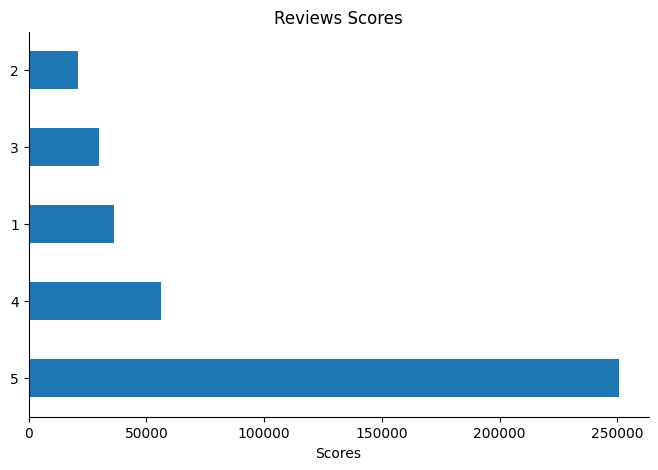

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))

df['Score'].value_counts()\
    .plot(kind='barh', 
          title='Reviews Scores', 
          figsize=(8, 5))
plt.xlabel('Scores')
ax.spines[['right', 'top']].set_visible(False)
#plt.savefig('/content/drive/MyDrive/DS/ВКР/NLP/Scors_Bar.jpeg')
plt.show()

## NLTK. Text preprocessing

In [7]:
nltk.download('words')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('stopwords')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df['Text'].iloc[15]

"My daughter loves twizzlers and this shipment of six pounds really hit the spot. It's exactly what you would expect...six packages of strawberry twizzlers."

In [18]:
df['Text'].iloc[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [ ]:
tokens = nltk.word_tokenize(df['Text'].iloc[15])
tokens[:10]

['My',
 'daughter',
 'loves',
 'twizzlers',
 'and',
 'this',
 'shipment',
 'of',
 'six',
 'pounds']

In [ ]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('My', 'PRP$'),
 ('daughter', 'NN'),
 ('loves', 'VBZ'),
 ('twizzlers', 'NNS'),
 ('and', 'CC'),
 ('this', 'DT'),
 ('shipment', 'NN'),
 ('of', 'IN'),
 ('six', 'CD'),
 ('pounds', 'NNS')]

In [ ]:
nltk_pos = pd.read_excel('/content/drive/MyDrive/DS/ВКР/NLP/NLTK_pos_tags.xlsx')
nltk_pos

,Abbreviation,Meaning
0,CC,coordinating conjunction
1,CD,cardinal digit
2,DT,determiner
3,EX,existential there
4,FW,foreign word
5,IN,preposition/subordinating conjunction
6,JJ,This NLTK POS Tag is an adjective (large)
7,JJR,"adjective, comparative (larger)"
8,JJS,"adjective, superlative (largest)"
9,LS,list market


In [ ]:
# Group words by POS
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  My/PRP$
  daughter/NN
  loves/VBZ
  twizzlers/NNS
  and/CC
  this/DT
  shipment/NN
  of/IN
  six/CD
  pounds/NNS
  really/RB
  hit/VBD
  the/DT
  spot/NN
  ./.
  It/PRP
  's/VBZ
  exactly/RB
  what/WP
  you/PRP
  would/MD
  expect/VB
  .../:
  six/CD
  packages/NNS
  of/IN
  strawberry/NN
  twizzlers/NNS
  ./.)


In [8]:
# Create stopword list:
df_stopwords = set(stopwords.words('english'))
df_stopwords.update(["br", "href"])

In [ ]:
len(df_stopwords)

181

In [ ]:
df_stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'br',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'href',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'ov

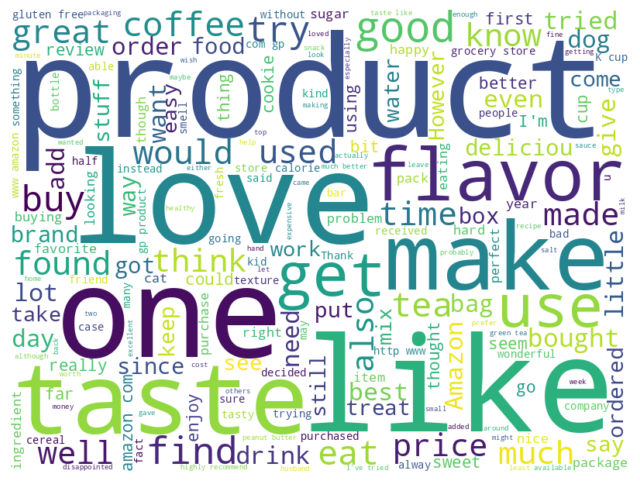

In [16]:
# Create a word cloud of the 'Text' column
text = ' '.join(df['Text'].astype(str).tolist())
wordcloud = WordCloud(
    width=800, 
    height=600, 
    background_color='white', 
    stopwords=df_stopwords).generate(text)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('/content/drive/MyDrive/DS/ВКР/NLP/wordcloud_gen.jpeg')
plt.show()

# Tweets classification

## VADER 

( Valence Aware Dictionary for Sentiment Reasoning) is an NLTK module that provides sentiment scores based on the words used. It is a rule-based sentiment analyzer in which the terms are generally labeled as per their semantic orientation as either positive or negative.

We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.

This uses a "bag of words" approach:<br>
Stop words are removed<br>
each word is scored and combined to a total score.

In [9]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
sia.polarity_scores('Live long and prosper!')

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [ ]:
sia.polarity_scores('burn in hell!')

{'neg': 0.71, 'neu': 0.29, 'pos': 0.0, 'compound': -0.7088}

In [ ]:
example1 = df['Text'].iloc[30]
example1

'This offer is a great price and a great taste, thanks Amazon for selling this product.<br /><br />Staral'

In [ ]:
sia.polarity_scores(example1)

{'neg': 0.0, 'neu': 0.484, 'pos': 0.516, 'compound': 0.9153}

In [ ]:
example2 = df['Text'].iloc[60]
example2

'This bag of candy online is pretty expensive, it should be cheaper in order to compete with grocery stores, other than that, its a good combination of my favorite candy'

In [ ]:
sia.polarity_scores(example2)

{'neg': 0.0, 'neu': 0.741, 'pos': 0.259, 'compound': 0.8442}

In [10]:
# Run the polarity score on the entire dataset
result = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    df_id = row['Id']
    result[df_id] = sia.polarity_scores(text)

  0%|          | 0/393565 [00:00<?, ?it/s]

In [11]:
vaders = pd.DataFrame(result)

In [12]:
vaders.head()

,1,2,3,4,5,6,7,8,9,10,...,568445,568446,568447,568448,568449,568450,568451,568452,568453,568454
neg,0.0000,0.1380,0.0910,0.0,0.0000,0.029,0.0340,0.0000,0.0000,0.0000,...,0.0000,0.0560,0.0740,0.031,0.1480,0.0720,0.1900,0.0370,0.0410,0.0000
neu,0.6950,0.8620,0.7540,1.0,0.5520,0.809,0.6930,0.5200,0.8510,0.7050,...,0.8570,0.8290,0.8220,0.845,0.7480,0.6000,0.6970,0.8840,0.5060,0.8460
pos,0.3050,0.0000,0.1550,0.0,0.4480,0.163,0.2730,0.4800,0.1490,0.2950,...,0.1430,0.1150,0.1040,0.124,0.1030,0.3270,0.1140,0.0780,0.4520,0.1540
compound,0.9441,-0.5664,0.8265,0.0,0.9468,0.883,0.9346,0.9487,0.6369,0.8313,...,0.6892,0.5251,0.1655,0.902,-0.0675,0.8589,-0.4848,0.4352,0.9717,0.4754


In [12]:
vaders = pd.DataFrame(result).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [14]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [19]:
df['Text'].iloc[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

### VADER results visualisation

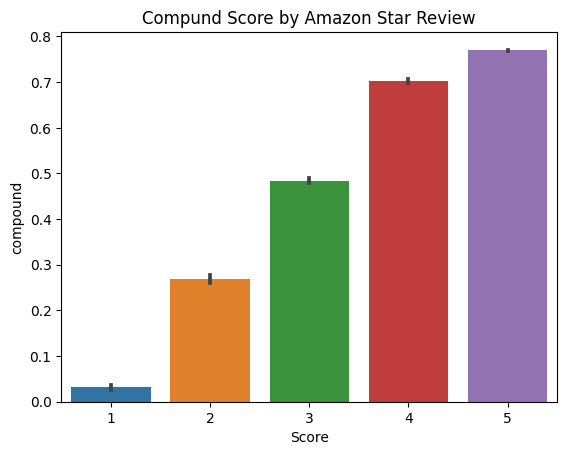

In [14]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
#plt.savefig('/content/drive/MyDrive/DS/ВКР/NLP/Compund Score by Amazon Star Review.jpeg')
plt.show()

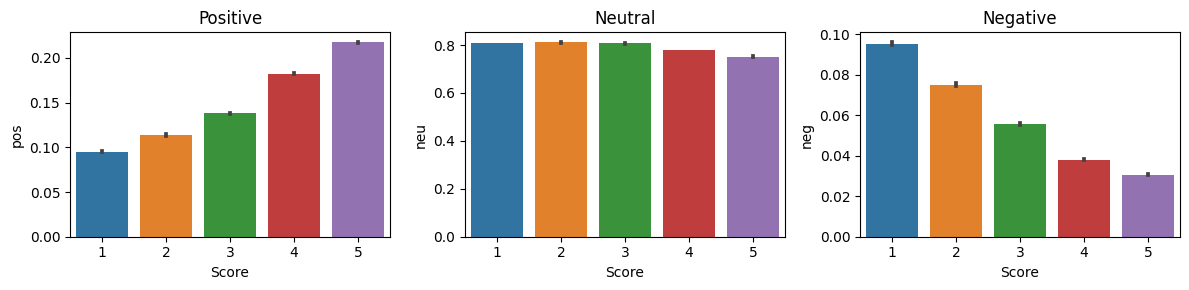

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
#plt.savefig('/content/drive/MyDrive/DS/ВКР/NLP/Scores by Amazon Star Review.jpeg')
plt.show()